# Cox生存分析

* `mydir`：自己的数据
* `ostime_column`: 数据对应的生存时间，不一定非的是OST，也可以是DST、FST等。
* `os`：生存状态，不一定非的是OS，也可以是DS、FS等。

In [24]:
from lifelines import CoxPHFitter
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.model_selection import train_test_split
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.comp1 import fillna

task_type = 'Combined_'
event_col = get_param_in_cwd('event_col', 'OS')
duration_col=get_param_in_cwd('duration_col', 'OSTime')
data = pd.read_csv('data/clinical.csv')
# data = normalize_df(data, not_norm='ID')
# label_data = pd.read_csv(get_param_in_cwd('label_file'))
# label_data = fillna(label_data, fill_mod='50%')
# data = pd.merge(data, label_data, on='ID', how='inner')
data

,ID,age,gender,T,N,M,Lauren_classification,Location,OS,OSTime,group
0,TCGA-BR-8368,84,0,1,0,0,0,0,0,131,test
1,TCGA-D7-8575,75,1,2,2,0,0,0,1,554,train
2,TCGA-VQ-A925,66,1,2,2,0,0,1,1,138,train
3,TCGA-RD-A7BT,66,1,2,3,0,0,0,1,262,train
4,TCGA-CD-A4MG,76,1,2,0,0,1,0,1,200,train
...,...,...,...,...,...,...,...,...,...,...,...
160,TCGA-RD-A8N6,78,0,1,2,0,0,1,1,272,train
161,TCGA-HU-A4GN,61,1,1,1,0,0,1,0,912,train
162,TCGA-BR-8484,61,1,3,1,0,0,0,1,766,test
163,TCGA-RD-A8NB,80,0,2,1,0,1,0,1,513,train


In [25]:
def get_sig(prefix):
    results = [pd.read_csv(f'results/{prefix}_cox_predictions_{subset}.csv')for subset in ['train', 'test']]
    results = pd.concat(results, axis=0)
    return results

path_sig = get_sig('Path')
path_sig.columns = ['ID', 'Pathology', '-']

mn = {'Path': 'Path', 'Clinical': 'Clinical'}
data = data[['ID', 'T', 'N', event_col, duration_col, 'group']]
for sig in ['Clinical', 'Path']:
    signature = get_sig(sig)
    signature.columns = ['ID', mn[sig], '-']
    data = pd.merge(data, signature, on='ID', how='inner')
# data = data[['ID', 'group', event_col, duration_col] + list(mn.values())]
# data = data[['ID', 'group', event_col, duration_col] + ['Pathology', 'Habitat']]
data

,ID,T,N,OS,OSTime,group,Clinical,-_x,Path,-_y
0,TCGA-BR-8368,1,0,0,131,test,0.432,1569.453,0.198,1604.627
1,TCGA-D7-8575,2,2,1,554,train,1.684,664.293,0.263,1422.141
2,TCGA-VQ-A925,2,2,1,138,train,0.897,1063.252,15.486,254.526
3,TCGA-RD-A7BT,2,3,1,262,train,1.926,594.581,25.736,210.422
4,TCGA-CD-A4MG,2,0,1,200,train,1.518,722.552,68.910,124.286
...,...,...,...,...,...,...,...,...,...,...
160,TCGA-RD-A8N6,1,2,1,272,train,0.422,1585.039,27.151,205.667
161,TCGA-HU-A4GN,1,1,0,912,train,0.351,1699.069,0.185,1644.306
162,TCGA-BR-8484,3,1,1,766,test,1.816,624.371,2.827,418.996
163,TCGA-RD-A8NB,2,1,1,513,train,1.481,736.786,0.184,1648.500


In [26]:
import numpy as np
import onekey_algo.custom.components as okcomp
from collections import OrderedDict

group_info = 'group'
train_data = data[(data[group_info] == 'train')]

# subsets = [s for s in label_data['group'].value_counts().index if s != 'train']
subsets = ['train', 'test']
val_datasets = OrderedDict()
for subset in subsets:
    val_data = data[data[group_info] == subset]
    val_datasets[subset] = val_data
    val_data.to_csv(f'features/{task_type}{subset}_cox.csv', index=False)

print('，'.join([f"{subset}样本数：{d_.shape}" for subset, d_ in val_datasets.items()]))

train样本数：(115, 10)，test样本数：(50, 10)


## Cox概览

所有Cox回归的必要数据，主要关注的数据有3个
1. `Concordance`: c-index
2. `exp(coef)`: 每个特征对应的HR，同时也有期对应的95%分位数。
3. `p`: 表示特征是否显著。

In [28]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.01)
cph.fit(train_data[[c for c in train_data.columns if c not in ['ID', 'group', 'Clinical'] and not c.startswith('-')]], 
        duration_col=duration_col, event_col=event_col)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 115 total observations, 62 right-censored observations>
             duration col = 'OSTime'
                event col = 'OS'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 115
number of events observed = 53
   partial log-likelihood = -177.62
         time fit was run = 2024-02-07 08:19:43 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
T           0.44       1.55       0.22             0.00             0.88                 1.00                 2.41
N           0.28       1.32       0.12             0.05             0.51                 1.05                 1.66
Path        0.07       1.07       0.01             0.05             0.08                 1.05                 1.08

            cmp to    z      p   -log2(p)
covariate                                
T             0.00 1.97   0.05       4.36
N             0.00 2.36   0.02       5.77
Path          0.00 8.12 <0.005      50.95
---
Concordance = 0.86
Partial AIC = 361.24
log-likelihood ratio test = 68.36 on 3 df
-log2(p) of ll-ratio test = 46.57

#### 输出每个特征的HR

In [29]:
cph.concordance_index_

0.856353591160221

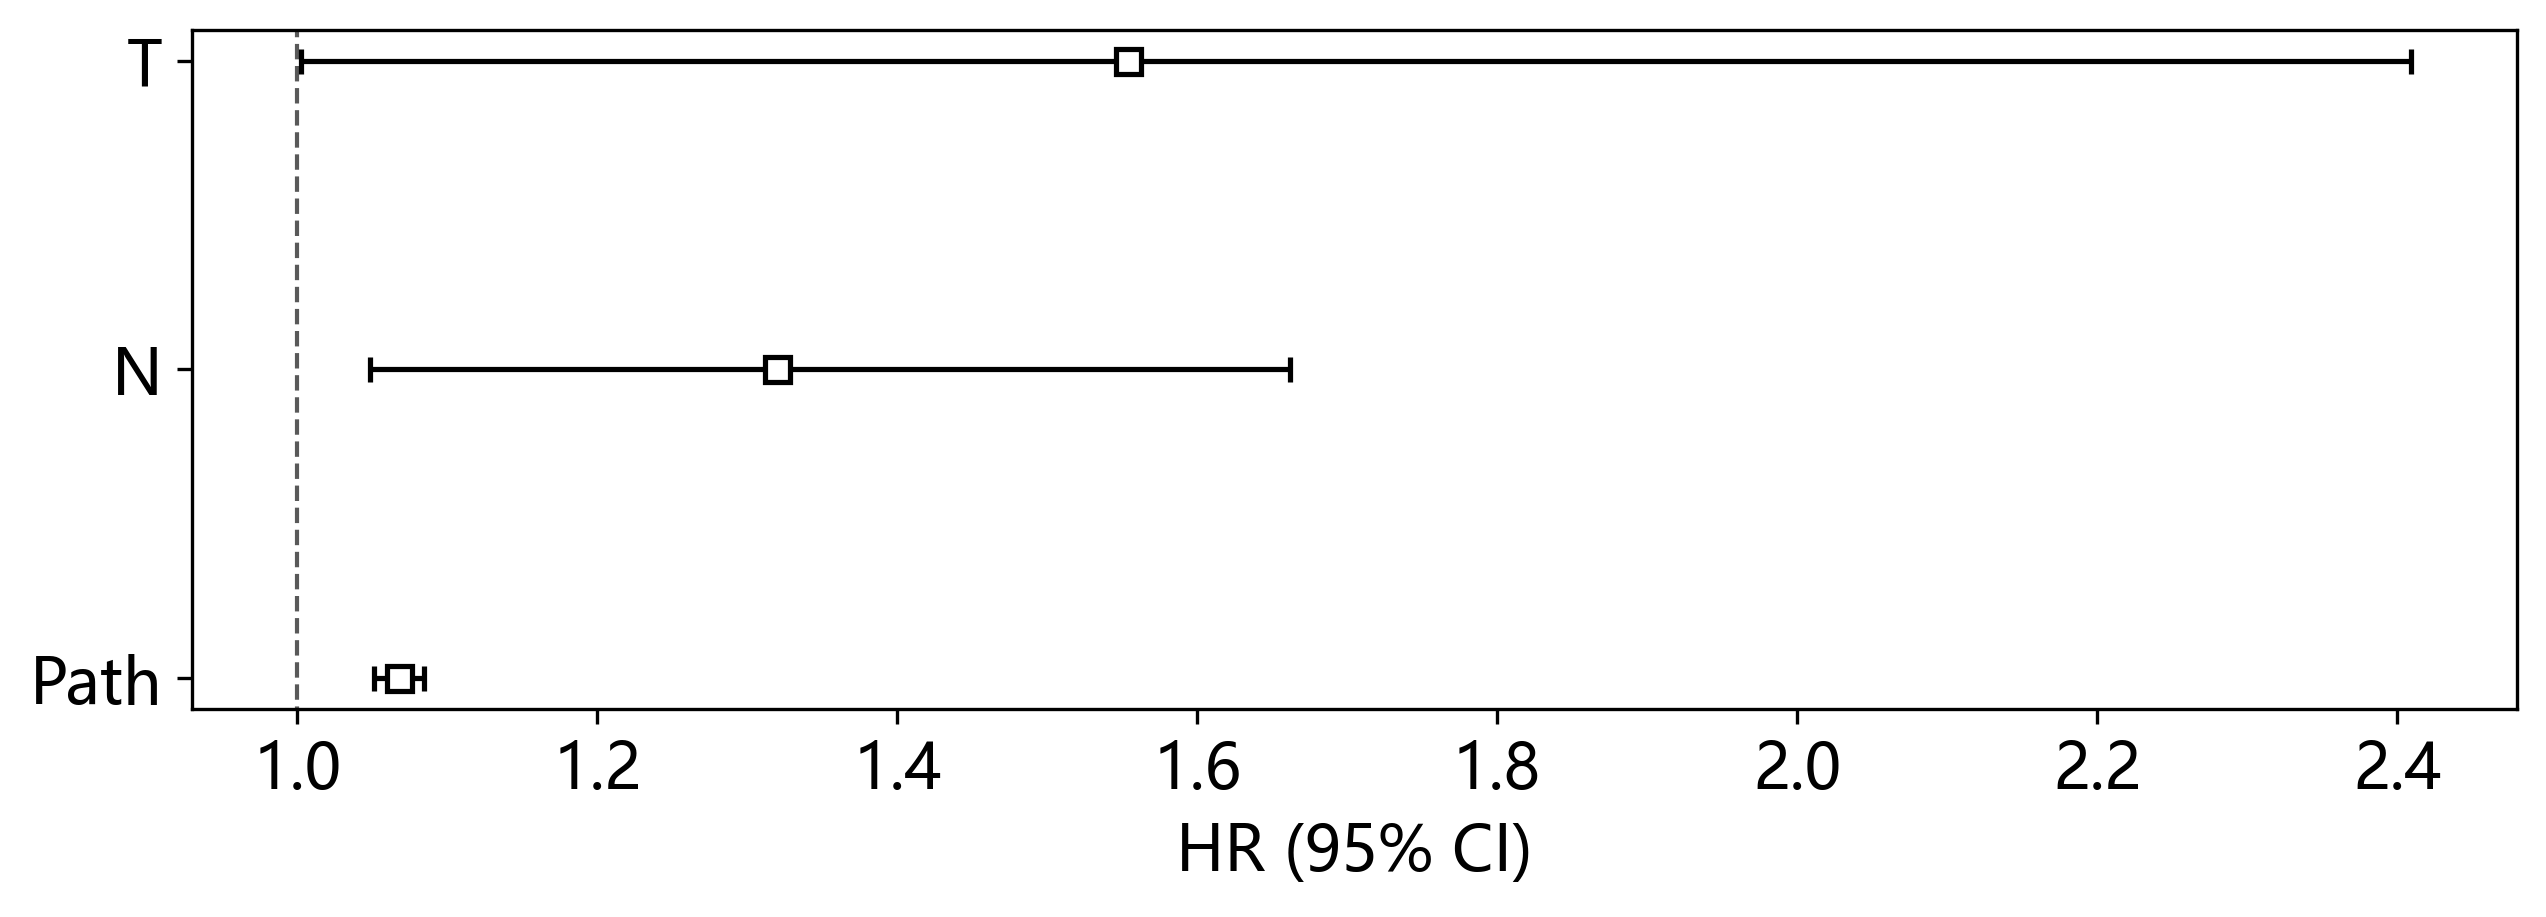

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
cph.plot(hazard_ratios=True)
plt.savefig(f'img/{task_type}_feature_pvalue.svg')
plt.show()

# KM 曲线

根据HR进行分组，计算KM以及log ranktest

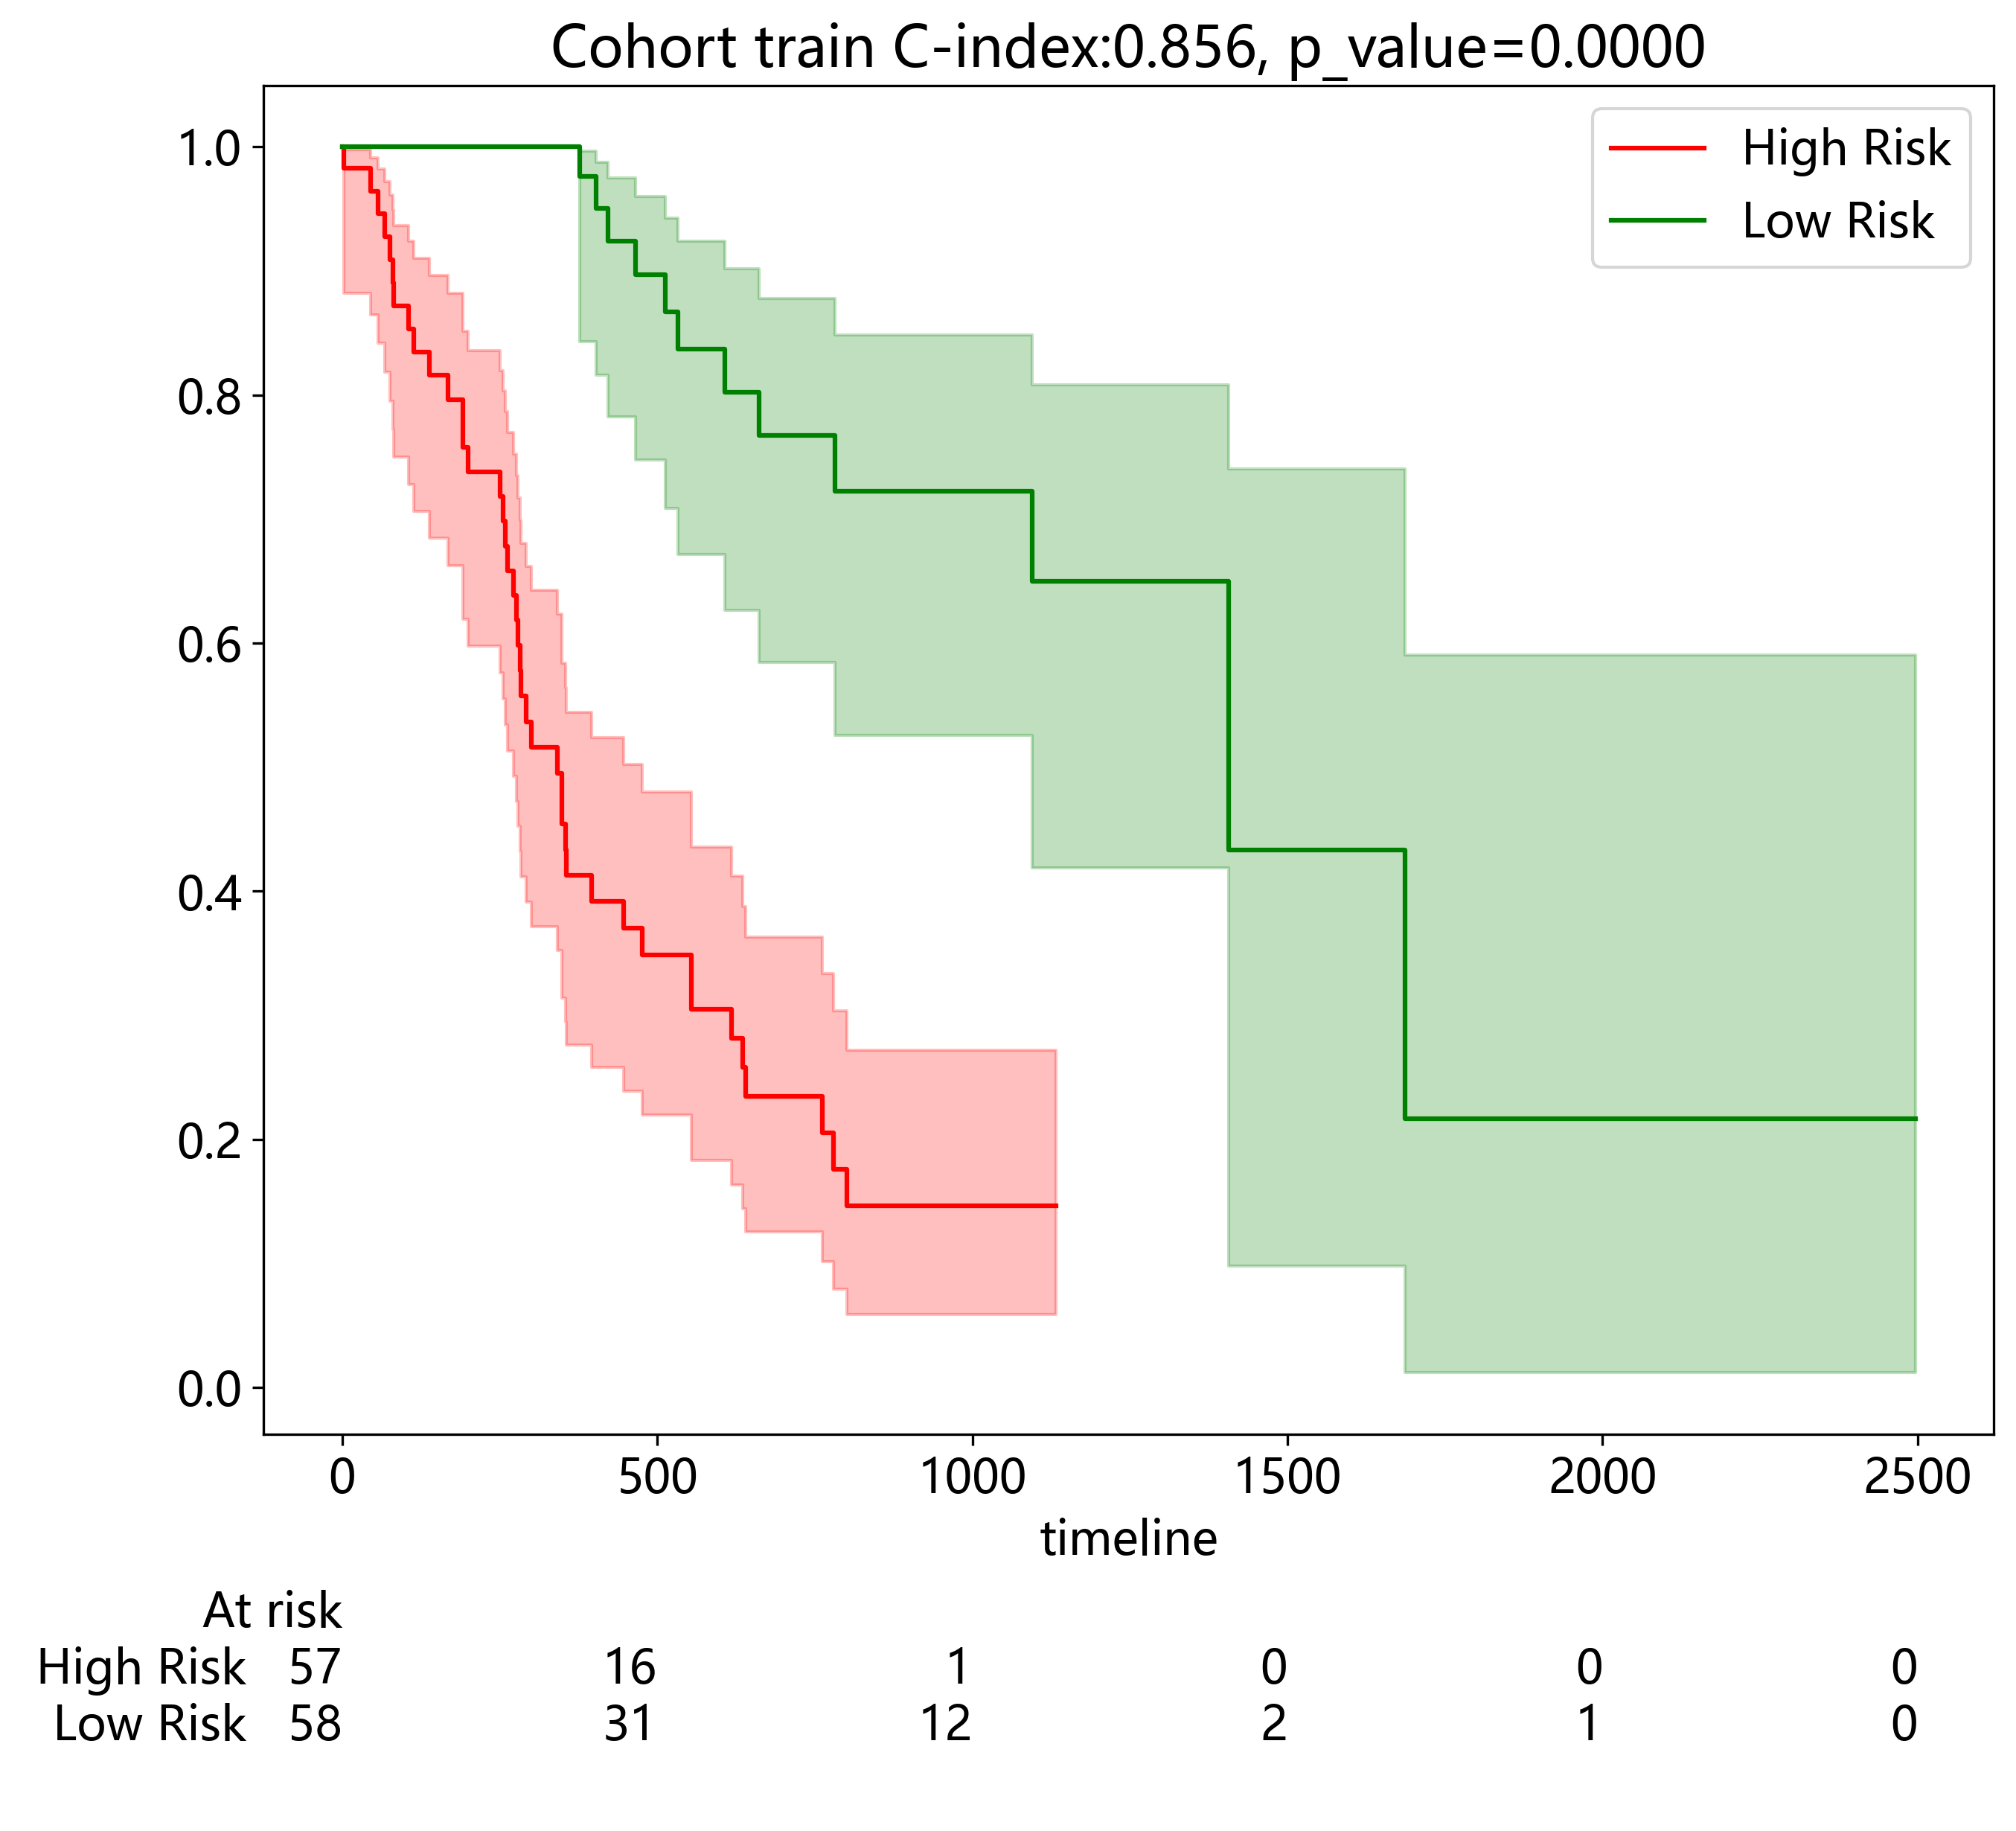

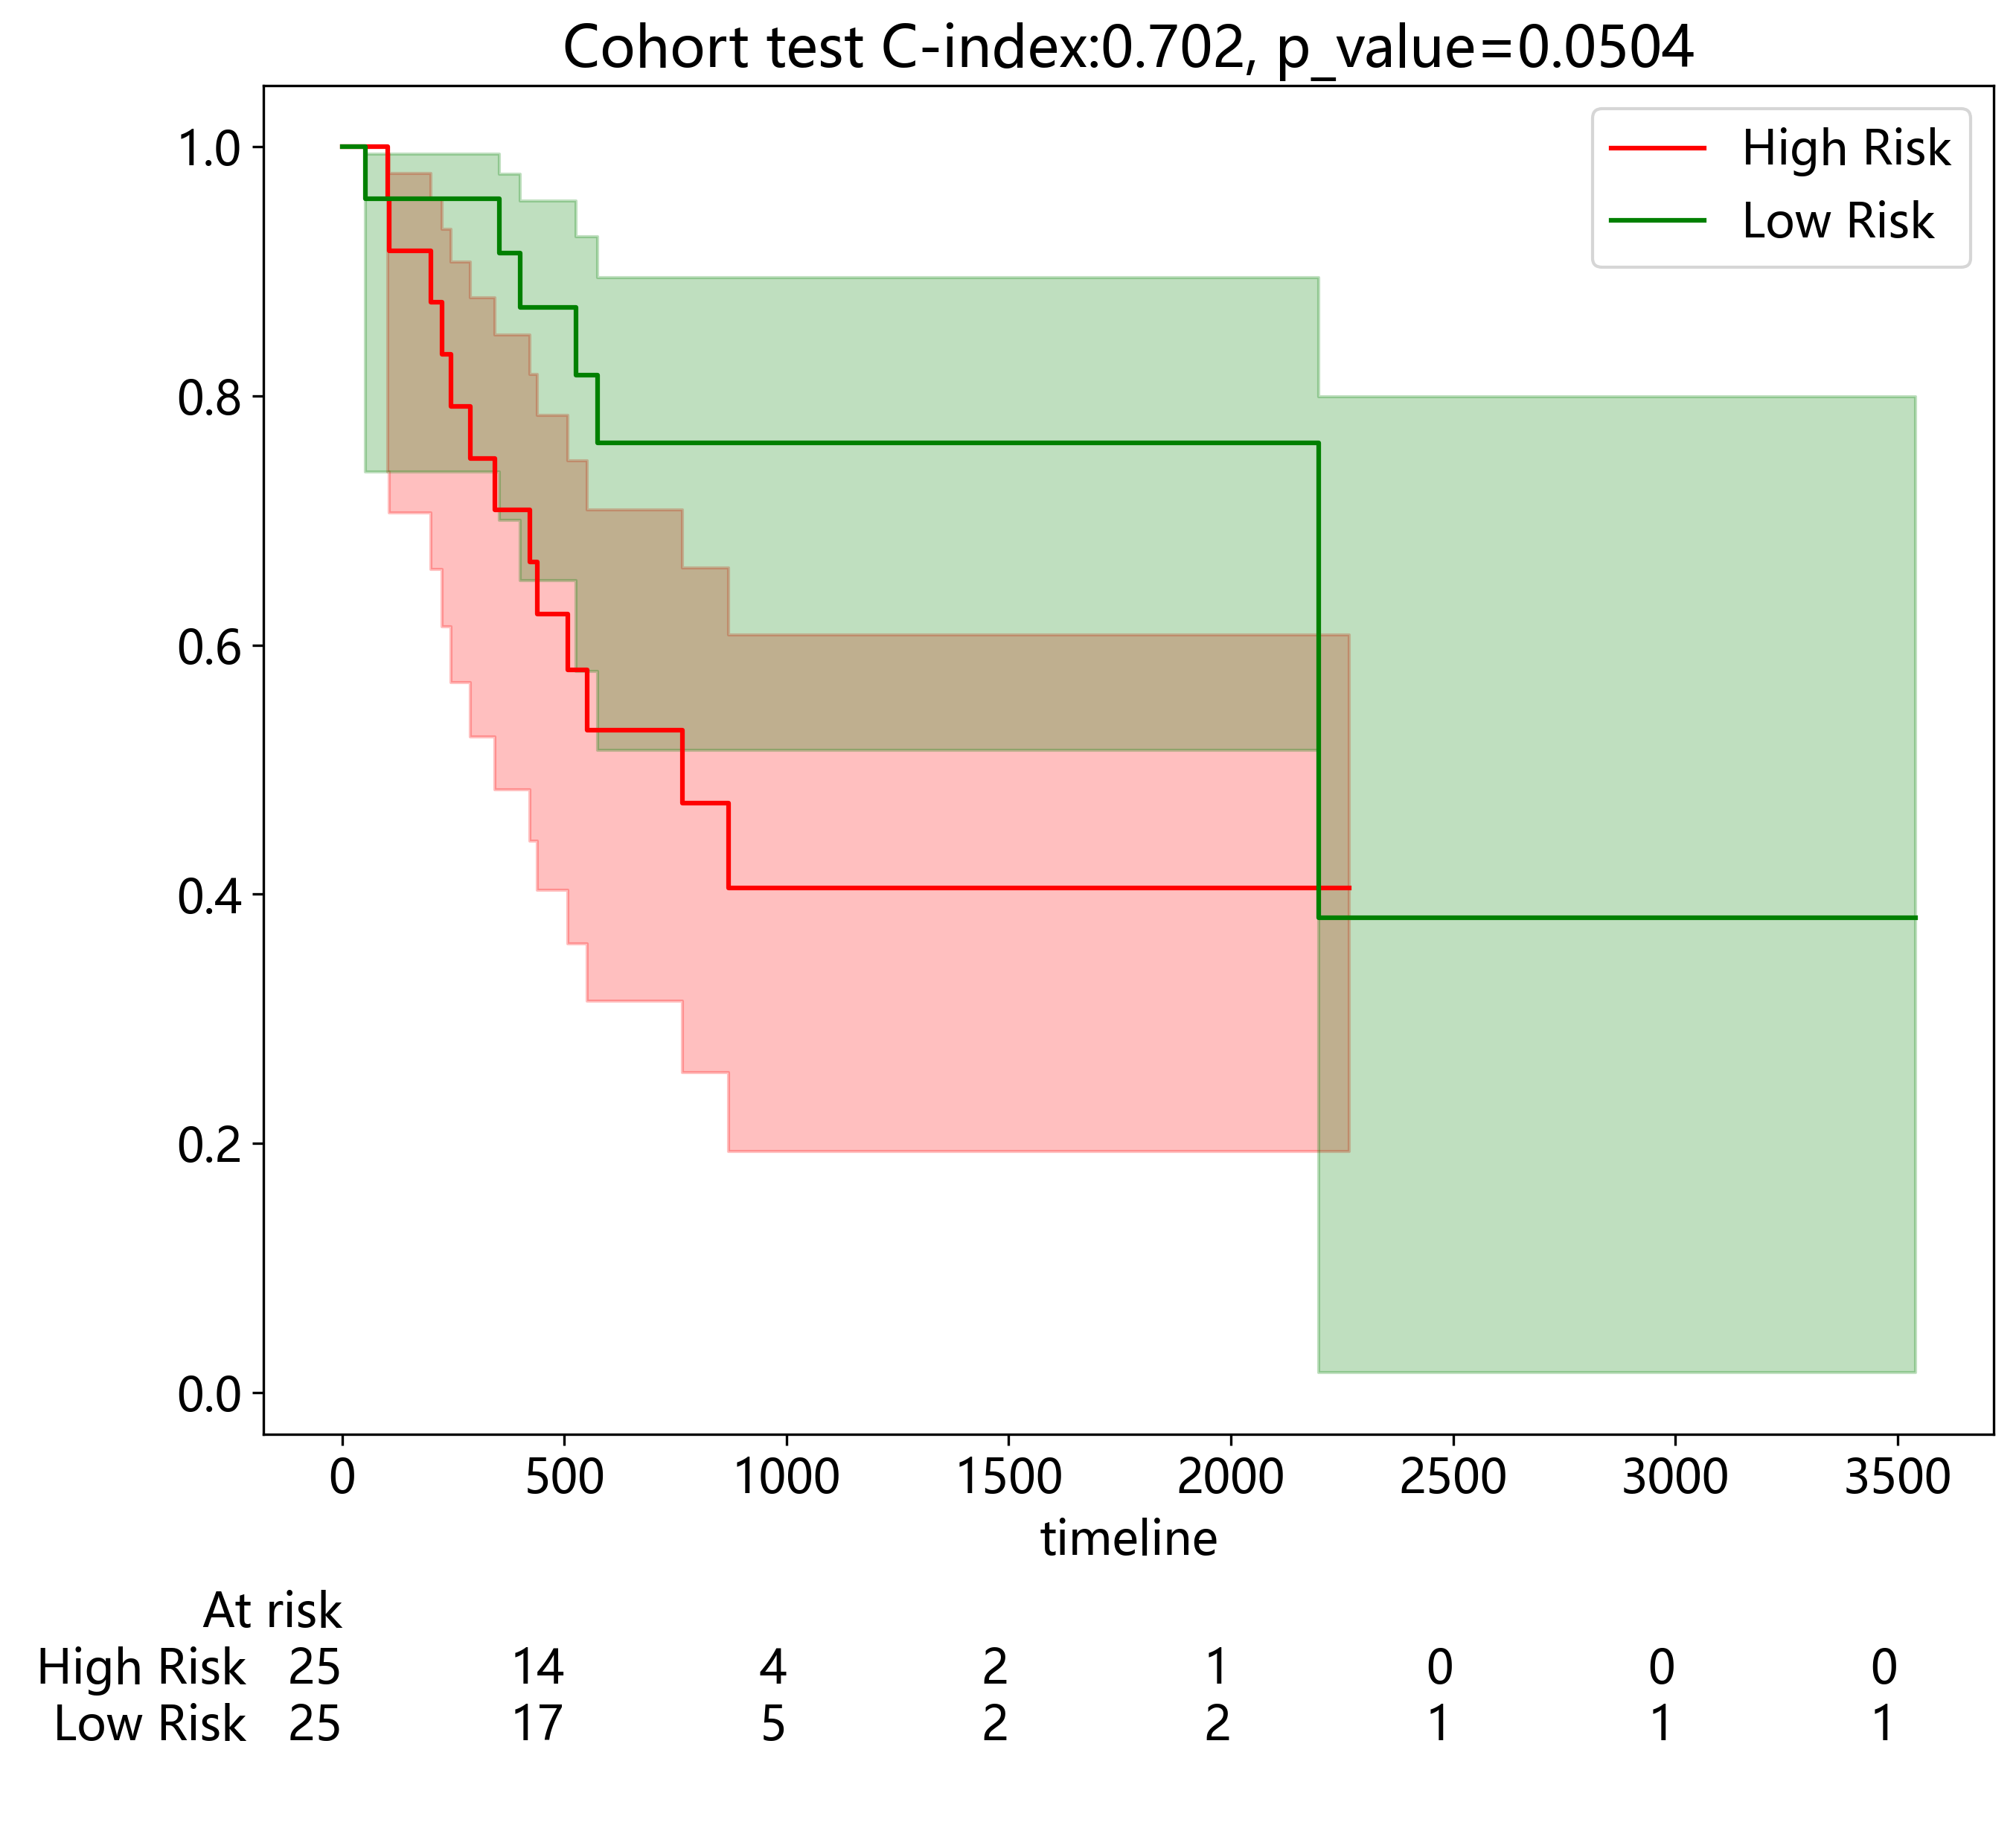

,Combined,Path,Clinical,Cohort
0,0.856,0.856,0.703,train
1,0.702,0.640,0.638,test


In [32]:
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.utils import concordance_index

c_index_list = []
for subset, test_data in val_datasets.items():
    if subset == 'test_ex':
        continue
    c_index = cph.score(test_data[[c for c in test_data.columns if c != 'ID']], scoring_method="concordance_index")
#     y_pred = cph.predict_median(test_data[[c for c in test_data.columns if c != 'ID']])
#     cox_data = pd.concat([test_data, y_pred], axis=1)
#     mean = cox_data.describe()[0.5]['mean']
#     cox_data['HR'] = cox_data[0.5] < mean
    y_pred = cph.predict_partial_hazard(test_data[[c for c in test_data.columns if c != 'ID']])
    cox_data = pd.concat([test_data, y_pred], axis=1)
    mean = cox_data.describe()[0]['50%']
    cox_data['HR'] = cox_data[0] > mean
#     cox_data['HR'] = cox_data[0] > 1

    dem = (cox_data["HR"] == True)
    results = logrank_test(cox_data[duration_col][dem], cox_data[duration_col][~dem], 
                           event_observed_A=cox_data[event_col][dem], event_observed_B=cox_data[event_col][~dem])
    p_value = results.p_value
    plt.title(f"Cohort {subset} C-index:{c_index:.3f}, p_value={p_value:.4f}")
    if sum(dem):
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(cox_data[duration_col][dem], event_observed=cox_data[event_col][dem], label="High Risk")
        kmf_high.plot_survival_function(color='r')
    if sum(~dem):
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(cox_data[duration_col][~dem], event_observed=cox_data[event_col][~dem], label="Low Risk")
        kmf_low.plot_survival_function(color='g')
    add_at_risk_counts(kmf_high, kmf_low, rows_to_show=['At risk'])
    plt.savefig(f'img/{task_type}KM_{subset}.svg', bbox_inches='tight')
    plt.show()
#     display(cox_data)
    c_index_list.append([c_index] + [concordance_index(cox_data[duration_col], -cox_data[c], cox_data[event_col])
                                     for c in mn.keys()] + [subset])
    
pd.DataFrame(c_index_list, columns=[task_type.strip('_')] + list(mn.keys()) + ['Cohort'])

In [33]:
import os
import numpy as np

def get_prediction(model: CoxPHFitter, data, ID=None, **kwargs):
    hr = model.predict_partial_hazard(data)
    expectation = model.predict_expectation(data)
    
    predictions = pd.concat([hr, expectation], axis=1)
    predictions.columns = ['HR', 'expectation']
    if ID is not None:
        predictions = pd.concat([ID, hr, expectation], axis=1)
        predictions.columns = ['ID', 'HR', 'expectation']
    else:
        predictions = pd.concat([hr, expectation], axis=1)
        predictions.columns = ['HR', 'expectation']
    return predictions
os.makedirs('results', exist_ok=True)
kids = []
for subset, test_data in val_datasets.items():
    resuslts = get_prediction(cph, test_data, ID=test_data['ID'])
    resuslts.to_csv(f'results/{task_type}cox_predictions_{subset}.csv', index=False)
    kids.append(resuslts['ID'])